# Time-series analysis (LSTM, 1D-CNN, 2D-CNN, …)
The aim of this lab (TP) is to a classification system of Human Activity Recognition (HAR).
The data used for classification is provided by the Wireless Sensor Data Mining (WISDM) Lab and can be downloaded directly from the course platform “actitracker_raw.txt”. It consists of 1,098,207 examples of various physical activities (sampled at 20Hz) with 6 attributes: user,activity,timestamp,x-acceleration,y-acceleration,z-acceleration.
The activities include: Walking, Jogging, Upstairs, Downstairs, Sitting, Standing. 

This data comes from the [University of Fordham](https://www.cis.fordham.edu/wisdm/dataset.php) and represents the accelerometer data while doing various activities. The aim is to determine which activity is done by analysing the sequence. According to the sources, the number of samples is equal to 1,098,207 divided in 6 classes :

*   Walking: 424,400 (38.6%)
*   Jogging: 342,177 (31.2%)
*   Upstairs: 122,869 (11.2%)
*   Downstairs: 100,427 (9.1%)
*   Sitting: 59,939 (5.5%)
*   Standing: 48,395 (4.4%)


Starting by downloading the data and aploading here:
https://drive.google.com/file/d/1eFEItgFg83sV9nZUI5MI5dV2D6OxPvKt/view?usp=sharing

We can use pandas to handle the time series. While displaying the values, we observe z-axis is not in the correct format because of the semicolon. we have to convert this data to numerical values. we can notice the presence of a NaN value so it's possible to use linear interpolation replace it.

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from zipfile import ZipFile
from google.colab.patches import cv2_imshow
import tensorflow as tf
import pandas as pd
from tensorflow.keras import models,optimizers,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import TensorBoard

Start by upload the data:

In [ ]:
import zipfile

with zipfile.ZipFile("actitracker_raw.txt.zip", 'r') as zip_ref:
    zip_ref.extractall("actitracker_raw")

In order to show how the x-acceleration was changing with time (or more accurately - at each timestep) for each one of these activities, you can use this function:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plotAxis(axis,x,y,title):
    axis.plot(x,y)
    axis.set_title(title)
    axis.xaxis.set_visible(False)
    axis.set_ylim([min(y)-np.std(y),max(y)+np.std(y)])
    axis.set_xlim([min(x),max(x)])
    axis.grid(True)

    
def plotActivity(activity,data):
    fig,(ax0,ax1,ax2) = plt.subplots(nrows=3, figsize=(15,10),sharex=True)
    plotAxis(ax0,data['timestamp'],data['x-axis'],'x-axis')
    plotAxis(ax1,data['timestamp'],data['y-axis'],'y-axis')
    plotAxis(ax2,data['timestamp'],data['z-axis'],'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [ ]:
def readData(filePath):
    # attributes of the dataset
    columnNames = ['user_id','activity','timestamp','x-axis','y-axis','z-axis']
    data = pd.read_csv(filePath,header = None, names=columnNames,na_values=';')
    return data


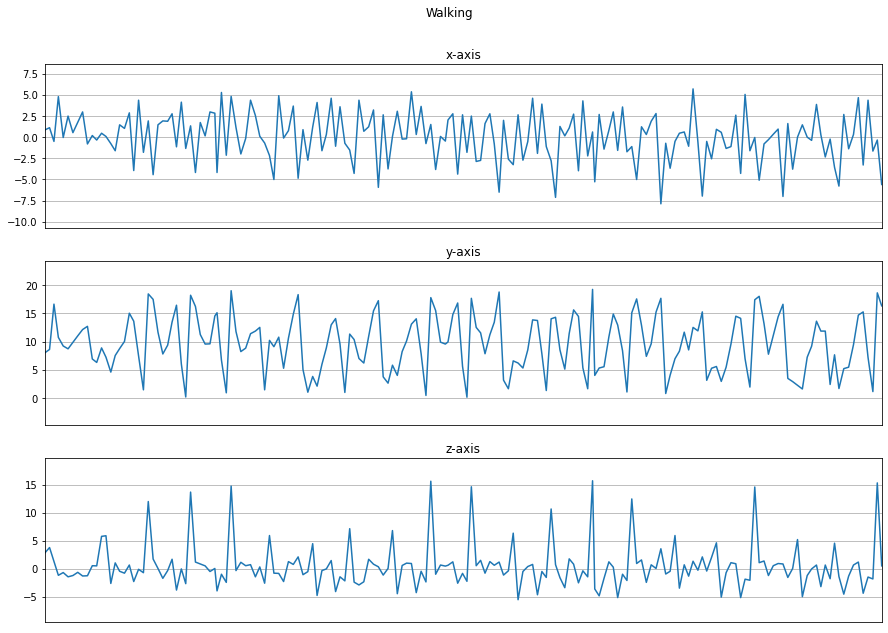

In [ ]:
dataset = readData('actitracker_raw/actitracker_raw.txt')
for activity in np.unique(dataset['activity']):
  subset = dataset[dataset['activity']==activity][:180]
  subset=subset.interpolate()

plotActivity(activity,subset)

In order to feed the network with such temporal dependencies a sliding time window is used to extract separate data segments. The window width and the step size can be both adjusted and optimised for better accuracy. Each time step is associated with an activity label, so for each segment the most frequently appearing label is chosen. Here, the time segment or window width is chosen to be 90.

In [ ]:
from scipy import stats
def windows(data,size):
    start = 0
    while start< data.count():
        yield int(start), int(start + size)
        start+= (size/2)
# segmenting the time series
def segment_signal(data, window_size = 90):
    segments = np.empty((0,window_size,3))
    labels= np.empty((0))
    for (start, end) in windows(data['timestamp'],window_size):
        x = data['x-axis'][start:end]
        y = data['y-axis'][start:end]
        z = data['z-axis'][start:end]
        if(len(data['timestamp'][start:end])==window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels =np.append(labels,stats.mode(data['activity'][start:end])[0][0])
    return segments, labels


The data needs to be separated into features and labels and then further into training and test sets. Labels need to be one-hot encoded before feeding into the classifier. Then,split the data into train/test subset as 80%/20%: train (19522 sequences) and test (4881 sequences).


### Comparing results between models:
These two functions are a diagnostic tool, the first one outputs different metrics, whereas the second one show confusion matrices of the three models (will be used in the exercice 3)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, plot_confusion_matrix
from sklearn.metrics import (
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    matthews_corrcoef,
)

def print_diagnostics(diags):
    print("\n")
    print("Precision: %1.3f" % diags[0])
    print("Recall: %1.3f" % diags[1])
    print("F1 score: %1.3f" % diags[2])
    print("MCC score: %1.3f" % diags[4])
    print("Accuracy: %1.3f" % diags[5])

    # plt.show()
    
def get_diagnostics(y_pred, y_valid, model_name,  print=False):
    """returns all evaluation metrics"""

    diags = (
        precision_score(y_valid, y_pred, average="macro"),
        recall_score(y_valid, y_pred, average="macro"),
        f1_score(y_valid, y_pred, average="macro"),
        matthews_corrcoef(y_valid, y_pred),
        accuracy_score(y_valid, y_pred),
    )
    if print:
        print_diagnostics(diags)
    return {"model": model_name, "precision": diags[0], "recall": diags[1], "F1-score": diags[2], "MCC": diags[3], "Accuracy": diags[4]}
def compare_models(y_test, y_pred1, y_pred2, y_pred3):
    fig, ax = plt.subplots(1,3, figsize=(20,5), facecolor="white")
    ax[0].set_title("2D CNN")
    ax[1].set_title("RNN")
    ax[2].set_title("1D CNN")
    fig.suptitle("Comparing models", fontsize=14)

    ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test, y_pred1), 
    display_labels = target_names).plot(ax=ax[0], colorbar=False, xticks_rotation=45)

    ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test, y_pred2), 
    display_labels = target_names).plot(ax=ax[1], colorbar=False, xticks_rotation=45)

    ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test, y_pred3), 
    display_labels = target_names).plot(ax=ax[2], colorbar=False, xticks_rotation=45)

In [ ]:
df_results = pd.DataFrame({})

# 1. Convolutional Neural Network (2D CNN)

If you concatenate the time series columns, you obtain a 2D matrix, on which you can apply a 2D CNN based classification system. Because we want to apply a 2D CNN, it is necessary to add a dimension to our sequences.


In [ ]:
segments, labels = segment_signal(dataset) 
reshapedSeg = segments.reshape(segments.shape[0], segments.shape[1], segments.shape[2], 1)

In [ ]:
print(np.array(segments).shape,np.array(labels).shape)

(24403, 90, 3) (24403,)


2D CNN need also that the format of labels to be in one hot encoding labels. 

In [ ]:
# here your code
from sklearn.model_selection import train_test_split
labels_enc = np.asarray(pd.get_dummies(labels),dtype = np.int8)
target_names = pd.get_dummies(labels).columns
X_train, X_test, y_train, y_test = train_test_split(reshapedSeg, labels_enc, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((19522, 90, 3, 1), (19522, 6), (4881, 90, 3, 1), (4881, 6))

In [ ]:
# # from sklearn.preprocessing import OneHotEncoder
# from keras.utils import to_categorical
# Y_train = to_categorical(y_train)
# Y_test = to_categorical(y_test)

Here, you can propose a classification system based on a 2DCNN (you can find an example of a suggested model here:)

In [ ]:
model_cnn  = tf.keras.Sequential()
model_cnn.add(layers.Conv2D(128, kernel_size=2, input_shape=(90, 3, 1), activation="relu"))
model_cnn.add(layers.BatchNormalization())
model_cnn.add(layers.MaxPooling2D(padding="valid"))
model_cnn.add(layers.Dropout(.5))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(128, activation="relu"))
model_cnn.add(layers.Dropout(.2))
model_cnn.add(layers.Dense(128, activation="relu"))
model_cnn.add(layers.Dense(6, activation="softmax"))
model_cnn.summary()

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 89, 2, 128)        640       
                                                                 
 batch_normalization_47 (Bat  (None, 89, 2, 128)       512       
 chNormalization)                                                
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 44, 1, 128)       0         
 g2D)                                                            
                                                                 
 dropout_60 (Dropout)        (None, 44, 1, 128)        0         
                                                                 
 flatten_31 (Flatten)        (None, 5632)              0         
                                                                 
 dense_141 (Dense)           (None, 128)             

**Question 1**: Plot performance curves that show the evaluation of the CNN model.

In [ ]:
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss="categorical_crossentropy",
              metrics=["acc"])

In [ ]:
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

In [ ]:
history_2DCNN = model_cnn.fit(X_train, y_train, batch_size=1024, epochs=50, validation_data=[X_test, y_test], verbose=2)

Epoch 1/50
20/20 - 1s - loss: 1.5040 - acc: 0.5837 - val_loss: 1.3783 - val_acc: 0.4614 - 1s/epoch - 51ms/step
Epoch 2/50
20/20 - 0s - loss: 0.7459 - acc: 0.7372 - val_loss: 1.5946 - val_acc: 0.4700 - 399ms/epoch - 20ms/step
Epoch 3/50
20/20 - 0s - loss: 0.6405 - acc: 0.7655 - val_loss: 1.8259 - val_acc: 0.4372 - 365ms/epoch - 18ms/step
Epoch 4/50
20/20 - 0s - loss: 0.5937 - acc: 0.7815 - val_loss: 1.5630 - val_acc: 0.4698 - 406ms/epoch - 20ms/step
Epoch 5/50
20/20 - 0s - loss: 0.5755 - acc: 0.7896 - val_loss: 1.1255 - val_acc: 0.5642 - 370ms/epoch - 19ms/step
Epoch 6/50
20/20 - 0s - loss: 0.5322 - acc: 0.8022 - val_loss: 1.0805 - val_acc: 0.5763 - 375ms/epoch - 19ms/step
Epoch 7/50
20/20 - 0s - loss: 0.4906 - acc: 0.8144 - val_loss: 0.8622 - val_acc: 0.6585 - 371ms/epoch - 19ms/step
Epoch 8/50
20/20 - 0s - loss: 0.4702 - acc: 0.8233 - val_loss: 0.8016 - val_acc: 0.6994 - 377ms/epoch - 19ms/step
Epoch 9/50
20/20 - 0s - loss: 0.4412 - acc: 0.8342 - val_loss: 0.6070 - val_acc: 0.7828 - 3

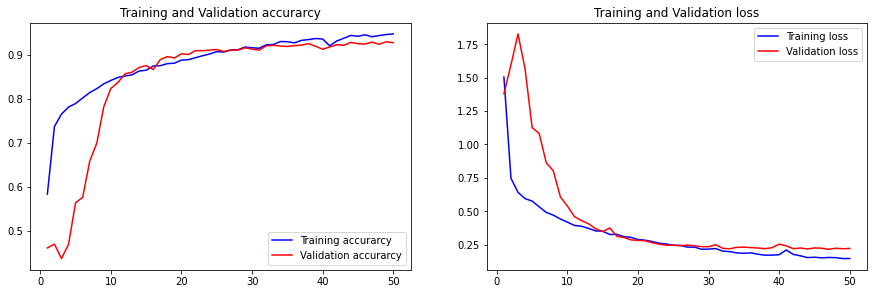

In [ ]:
acc = history_2DCNN.history['acc']
val_acc = history_2DCNN.history['val_acc']
loss = history_2DCNN.history['loss']
val_loss = history_2DCNN.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.subplot(2,2,2)
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
y_true = np.argmax(y_test, axis=1)
y_pred1 = np.argmax(model_cnn.predict(X_test), axis=1)
df_results = df_results.append(get_diagnostics(y_pred1, y_true, "CNN 2D"), ignore_index=True)

153/153 [==============================] - 0s 2ms/step


**2.	Long-Short-Terms-Memory (LSTM)**


Configures an RNN as following:


In [ ]:
# your model here
RNN  = tf.keras.Sequential()
RNN.add(layers.LSTM(128, activation="tanh", return_sequences=True, input_shape=(90, 3)))
RNN.add(layers.BatchNormalization())
# RNN.add(layers.Dropout(.3))
RNN.add(layers.LSTM(128, activation="tanh", return_sequences=False, input_shape=(90, 128)))
RNN.add(layers.BatchNormalization())
RNN.add(layers.Dense(32, activation="tanh"))
RNN.add(layers.Dropout(.5))
RNN.add(layers.Dense(6, activation="softmax"))
RNN.summary()
# print(RNN.summary())

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 90, 128)           67584     
                                                                 
 batch_normalization_41 (Bat  (None, 90, 128)          512       
 chNormalization)                                                
                                                                 
 lstm_29 (LSTM)              (None, 128)               131584    
                                                                 
 batch_normalization_42 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_126 (Dense)           (None, 32)                4128      
                                                                 
 dropout_53 (Dropout)        (None, 32)              

**Question 2:** Plot performance curves that show the evaluation of the LSTM model and compare it to the previous CNN model.

In [ ]:
RNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss="categorical_crossentropy",
              metrics=["acc"])
history_RNN = RNN.fit(X_train, y_train, batch_size=1024, epochs=50, validation_data=[X_test, y_test])

Epoch 1/50
20/20 [==============================] - 5s 106ms/step - loss: 1.1159 - acc: 0.6259 - val_loss: 1.3225 - val_acc: 0.5323
Epoch 2/50
20/20 [==============================] - 1s 65ms/step - loss: 0.7134 - acc: 0.7743 - val_loss: 1.2407 - val_acc: 0.5999
Epoch 3/50
20/20 [==============================] - 1s 65ms/step - loss: 0.5783 - acc: 0.8122 - val_loss: 1.1378 - val_acc: 0.6880
Epoch 4/50
20/20 [==============================] - 1s 65ms/step - loss: 0.5275 - acc: 0.8222 - val_loss: 1.1300 - val_acc: 0.6988
Epoch 5/50
20/20 [==============================] - 1s 67ms/step - loss: 0.4510 - acc: 0.8508 - val_loss: 0.7456 - val_acc: 0.7574
Epoch 6/50
20/20 [==============================] - 1s 65ms/step - loss: 0.4217 - acc: 0.8612 - val_loss: 1.2473 - val_acc: 0.7199
Epoch 7/50
20/20 [==============================] - 1s 65ms/step - loss: 0.3478 - acc: 0.8887 - val_loss: 0.8564 - val_acc: 0.7767
Epoch 8/50
20/20 [==============================] - 1s 65ms/step - loss: 0.3062 - 

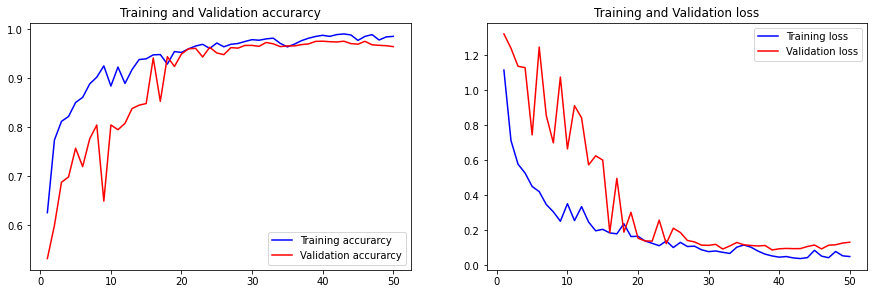

In [ ]:
acc = history_RNN.history['acc']
val_acc = history_RNN.history['val_acc']
loss = history_RNN.history['loss']
val_loss = history_RNN.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.subplot(2,2,2)
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred2 = np.argmax(RNN.predict(X_test), axis=1)
df_results = df_results.append(get_diagnostics(y_pred2, y_true, "RNN"), ignore_index=True)

153/153 [==============================] - 1s 7ms/step


In [ ]:
df_results

,model,precision,recall,F1-score,MCC,Accuracy
0,CNN 2D,0.968397,0.966476,0.967408,0.967003,0.97603
1,RNN,0.964028,0.966588,0.965028,0.966035,0.97521


**3. Convolutional Neural Network (1D CNN)**

1D CNN can perform activity recognition task from accelerometer data, such as if the person is standing, walking, jumping etc. This data has 2 dimensions. The first dimension is time-steps and other is the values of the acceleration in 3 axes. To add a Conv1D layer in keras for example:

In [ ]:
#from tensorflow.keras.layers import Conv1D
#model = models.Sequential()
#model.add(Conv1D(1, kernel_size=5, input_shape = (120, 3)))

In [ ]:
model_1D = tf.keras.Sequential()
model_1D.add(layers.Conv1D(100, kernel_size=5, input_shape = (90, 3), activation="relu"))
model_1D.add(layers.Conv1D(100, kernel_size=5,  activation="relu"))

# model_1D.add(layers.BatchNormalization())
model_1D.add(layers.MaxPooling1D(3))
model_1D.add(layers.Conv1D(160, kernel_size=5,  activation="relu"))
model_1D.add(layers.Conv1D(160, kernel_size=5,  activation="relu"))
model_1D.add(layers.GlobalAveragePooling1D())
model_1D.add(layers.Dropout(.5))
model_1D.add(layers.Dense(6, activation="softmax"))
model_1D.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 86, 100)           1600      
                                                                 
 conv1d_29 (Conv1D)          (None, 82, 100)           50100     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 27, 100)          0         
 1D)                                                             
                                                                 
 conv1d_30 (Conv1D)          (None, 23, 160)           80160     
                                                                 
 conv1d_31 (Conv1D)          (None, 19, 160)           128160    
                                                                 
 global_average_pooling1d_7   (None, 160)              0         
 (GlobalAveragePooling1D)                            

**Question 3:** Test the performance of this model and compare it to the previous models.

In [ ]:
model_1D.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss="categorical_crossentropy",
              metrics=["acc"])
history_1D = model_1D.fit(X_train, y_train, batch_size=1024, epochs=50, validation_data=[X_test, y_test])

Epoch 1/50
20/20 [==============================] - 3s 81ms/step - loss: 1.0551 - acc: 0.6232 - val_loss: 0.6373 - val_acc: 0.7412
Epoch 2/50
20/20 [==============================] - 1s 34ms/step - loss: 0.5705 - acc: 0.7930 - val_loss: 0.4146 - val_acc: 0.8447
Epoch 3/50
20/20 [==============================] - 1s 34ms/step - loss: 0.4052 - acc: 0.8543 - val_loss: 0.2905 - val_acc: 0.8939
Epoch 4/50
20/20 [==============================] - 1s 35ms/step - loss: 0.3035 - acc: 0.8964 - val_loss: 0.2296 - val_acc: 0.9230
Epoch 5/50
20/20 [==============================] - 1s 35ms/step - loss: 0.2477 - acc: 0.9172 - val_loss: 0.2058 - val_acc: 0.9291
Epoch 6/50
20/20 [==============================] - 1s 34ms/step - loss: 0.2011 - acc: 0.9366 - val_loss: 0.1683 - val_acc: 0.9437
Epoch 7/50
20/20 [==============================] - 1s 35ms/step - loss: 0.1848 - acc: 0.9388 - val_loss: 0.1377 - val_acc: 0.9539
Epoch 8/50
20/20 [==============================] - 1s 34ms/step - loss: 0.1514 - a

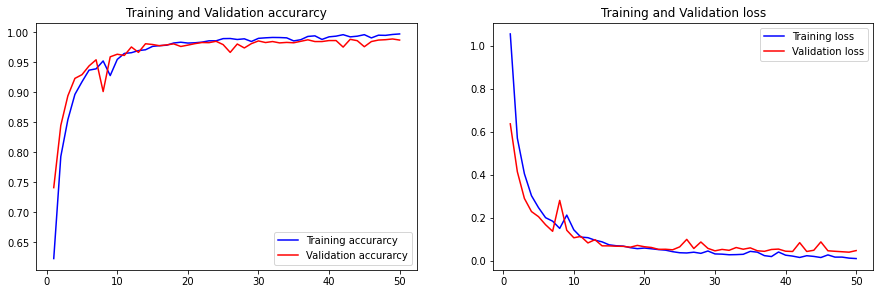

In [ ]:
acc = history_1D.history['acc']
val_acc = history_1D.history['val_acc']
loss = history_1D.history['loss']
val_loss = history_1D.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.subplot(2,2,2)
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred3 = np.argmax(model_1D.predict(X_test), axis=1)
df_results = df_results.append(get_diagnostics(y_pred3, y_true, "CNN 1D"), ignore_index=True)

153/153 [==============================] - 0s 3ms/step


In [ ]:
df_results

,model,precision,recall,F1-score,MCC,Accuracy
0,CNN 2D,0.968397,0.966476,0.967408,0.967003,0.976030
1,RNN,0.964028,0.966588,0.965028,0.966035,0.975210
2,CNN 1D,0.995835,0.994467,0.995129,0.995211,0.996517


153/153 [==============================] - 0s 2ms/step


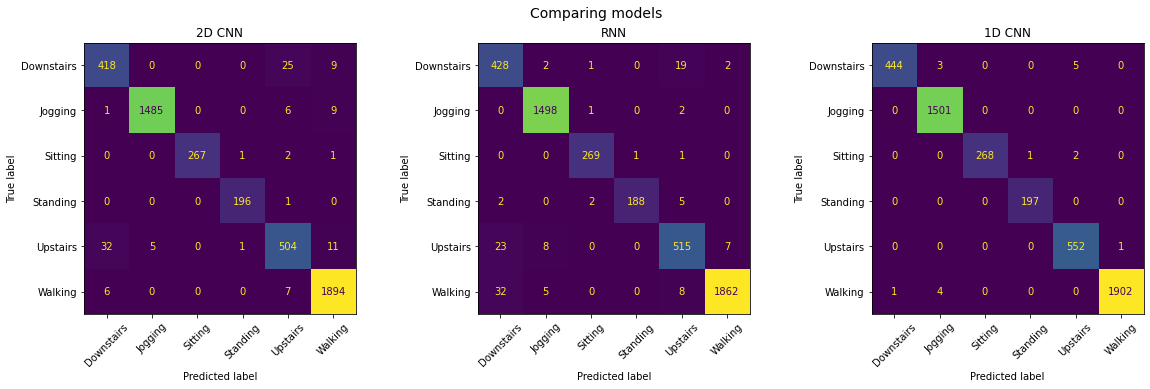

In [ ]:
compare_models(y_true, y_pred1, y_pred2, y_pred3)

**Question 4:** Extend this model to the 3D Action dataset (based on seen at the last lab (TP GAN). 

**Question 4:** Extend this model to the Action Recognition from 2D skeleton data. 
To do this, you can use this folder contating 3D joints captured from video.
https://drive.google.com/file/d/1PIUkA5ZXb2HFQ9VbLMxQGAjJTkr56YNj/view?usp=sharing
five actions are considered: squat, stand, punch, kick, and wave. The videos are recorded at 10 fps with a frame size of 640 x 480, and then saved to images. From each image, a 2D skeleton is extarcted usin g Open Pose tools.

The generated training data files are located in data folder:
*   skeleton_raw.csv: original data
*   skeleton_filtered.csv: filtered data where incomplete poses are eliminated

In [ ]:
with ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall("skeleton_data")

In [ ]:
skeleton_data = pd.read_csv("skeleton_data/data/skeleton_filtered.csv")


In [ ]:
skeleton_data

,nose_x,nose_y,neck_x,neck_y,Rshoulder_x,Rshoulder_y,Relbow_x,Relbow_y,Rwrist_x,RWrist_y,...,LAnkle_y,REye_x,REye_y,LEye_x,LEye_y,REar_x,REar_y,LEar_x,LEar_y,class
0,0.643519,0.157609,0.634259,0.250000,0.587963,0.244565,0.555556,0.342391,0.550926,0.434783,...,0.755435,0.629630,0.146739,0.652778,0.146739,0.615741,0.157609,0.666667,0.152174,kick
1,0.643519,0.157609,0.634259,0.250000,0.587963,0.244565,0.560185,0.342391,0.555556,0.429348,...,0.766304,0.629630,0.146739,0.652778,0.146739,0.615741,0.157609,0.666667,0.152174,kick
2,0.643519,0.157609,0.638889,0.250000,0.587963,0.244565,0.560185,0.342391,0.555556,0.429348,...,0.760870,0.634259,0.146739,0.652778,0.146739,0.615741,0.157609,0.671296,0.152174,kick
3,0.643519,0.157609,0.638889,0.250000,0.587963,0.244565,0.560185,0.342391,0.555556,0.429348,...,0.755435,0.629630,0.146739,0.652778,0.146739,0.615741,0.157609,0.666667,0.152174,kick
4,0.643519,0.157609,0.638889,0.250000,0.587963,0.244565,0.560185,0.342391,0.555556,0.429348,...,0.760870,0.629630,0.146739,0.652778,0.146739,0.615741,0.157609,0.666667,0.152174,kick
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3219,0.587963,0.152174,0.587963,0.233696,0.541667,0.217391,0.500000,0.163043,0.486111,0.092391,...,0.755435,0.578704,0.141304,0.597222,0.141304,0.564815,0.152174,0.620370,0.146739,wave
3220,0.583333,0.157609,0.587963,0.233696,0.541667,0.222826,0.490741,0.179348,0.458333,0.114130,...,0.755435,0.574074,0.141304,0.597222,0.141304,0.564815,0.152174,0.615741,0.146739,wave
3221,0.583333,0.157609,0.587963,0.228261,0.537037,0.222826,0.481481,0.179348,0.439815,0.108696,...,0.755435,0.574074,0.141304,0.000000,0.000000,0.560185,0.146739,0.615741,0.146739,wave
3222,0.578704,0.157609,0.583333,0.228261,0.532407,0.222826,0.476852,0.184783,0.421296,0.125000,...,0.755435,0.569444,0.146739,0.592593,0.141304,0.560185,0.152174,0.611111,0.146739,wave


In [ ]:
X = skeleton_data[skeleton_data.columns[:-1]]
labels = skeleton_data["class"]

In [ ]:
from sklearn.model_selection import train_test_split

labels_enc = np.asarray(pd.get_dummies(labels),dtype = np.int8)
target_names = pd.get_dummies(labels).columns
X = np.asarray(X)
print(X.shape)
reshapedX = X.reshape(X.shape[0], X.shape[1], 1)
X_train, X_test, y_train, y_test = train_test_split(X, labels_enc, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(3224, 36)


((2579, 36), (2579, 5), (645, 36), (645, 5))

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
# your model here
RNN  = tf.keras.Sequential()
RNN.add(layers.LSTM(128, activation="tanh", return_sequences=True, input_shape=(36,1)))
RNN.add(layers.BatchNormalization())
RNN.add(layers.Dropout(.5))
RNN.add(layers.LSTM(128, activation="tanh", return_sequences=False))
RNN.add(layers.BatchNormalization())
RNN.add(layers.Dense(32, activation="tanh"))
RNN.add(layers.Dropout(.5))
RNN.add(layers.Dense(5, activation="softmax"))
RNN.summary()
# print(RNN.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 36, 128)           66560     
                                                                 
 batch_normalization_22 (Bat  (None, 36, 128)          512       
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 36, 128)           0         
                                                                 
 lstm_25 (LSTM)              (None, 128)               131584    
                                                                 
 batch_normalization_23 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_23 (Dense)            (None, 32)              

In [ ]:
RNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss="categorical_crossentropy",
              metrics=["acc"])
history_1D = RNN.fit(X_train, y_train, batch_size=256, epochs=100, validation_data=[X_test, y_test])

Epoch 1/100
11/11 [==============================] - 5s 132ms/step - loss: 1.4574 - acc: 0.4529 - val_loss: 1.5192 - val_acc: 0.2698
Epoch 2/100
11/11 [==============================] - 0s 23ms/step - loss: 1.2294 - acc: 0.5145 - val_loss: 1.5227 - val_acc: 0.2558
Epoch 3/100
11/11 [==============================] - 0s 19ms/step - loss: 1.0977 - acc: 0.5715 - val_loss: 1.5944 - val_acc: 0.2574
Epoch 4/100
11/11 [==============================] - 0s 20ms/step - loss: 1.0386 - acc: 0.5886 - val_loss: 1.6384 - val_acc: 0.2651
Epoch 5/100
11/11 [==============================] - 0s 16ms/step - loss: 0.9920 - acc: 0.6177 - val_loss: 1.6671 - val_acc: 0.2636
Epoch 6/100
11/11 [==============================] - 0s 16ms/step - loss: 0.9017 - acc: 0.6526 - val_loss: 1.6938 - val_acc: 0.2651
Epoch 7/100
11/11 [==============================] - 0s 16ms/step - loss: 0.8450 - acc: 0.6673 - val_loss: 1.7995 - val_acc: 0.2605
Epoch 8/100
11/11 [==============================] - 0s 15ms/step - loss: 0

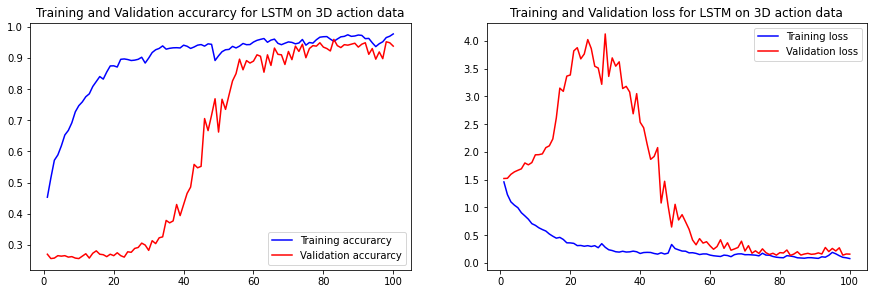

In [ ]:
acc = history_1D.history['acc']
val_acc = history_1D.history['val_acc']
loss = history_1D.history['loss']
val_loss = history_1D.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy for LSTM on 3D action data')
plt.legend()
plt.subplot(2,2,2)
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss for LSTM on 3D action data')
plt.legend()
plt.show()

Avec l'ajout des méthodes de normalisation au modèle LSTM, le modèle arrive à se stabiliser après 50 epochs. On peut remarquer toutefois qu'il passe par une étape transitoire où l'accuracy n'augmente pas mais la loss en validation augmente. Plusieurs architectures ont été essayées, mais le résultat reste le même. On peut conclure que pour ce dataset, le modèle doit passer plus de temps avant de commencer à apprendre à généraliser.